# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


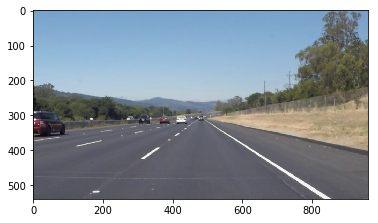

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [26]:
import math
from statistics import mean

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    leftLine = []
    rightLine = []
    
    leftSlope = 0
    rightSlope = 0
    x1l = 0
    x1r = 0
    x2l = 0
    x2r = 0
    totalLengthL = 0
    totalLengthR = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 < 110 or x1 > 840 or x2 < 110 or x2 > 840 or y1 < 300 or y2 < 300:
                continue
            slope = (y2-y1)/(x2-x1)
            weight = math.hypot(x2 - x1, y2 - y1)
            if slope > 0:
                x1l += x1
                x2l += x2
                if slope > 0.4 and not math.isnan(slope):
                    totalLengthL += weight
                    leftSlope += slope*weight
                    leftLine.append(line)
            else:
                x1r += x1
                x2r += x2
                if slope < -0.4 and not math.isnan(slope):
                    rightSlope += slope*weight
                    rightLine.append(line)
                    totalLengthR += weight
                
    # Find the average slope for each side. 
    if totalLengthL != 0:
        leftSlope/=totalLengthL
    else: 
        return
    if totalLengthR != 0:
        rightSlope/=totalLengthR
    else: 
        return
    
    # Find average x values for each point
    x1l//=len(leftLine)
    x2l//=len(leftLine)
    x1r//=len(rightLine)
    x2r//=len(rightLine)
    
    #(y-y') =M(x-x')
    #(540 - 335) = slope(x - 485)
    #205 = leftSlope*x - slope*485
    #leftSlope*x = - slope*485 - 225
    #x = -485 (-225)/slope

    rightIntercept = 540 - int(190/rightSlope)
    leftIntercept = 430 - int(190/leftSlope)
    
    print (leftIntercept, rightIntercept)
    #now that we have the slope of the lines, we can extrapolate from the bottom of the image
    cv2.line(img, (leftIntercept, 540), (430, 350), color, thickness)
    cv2.line(img, (rightIntercept, 540), (540, 350), color, thickness)
    print(leftSlope, rightSlope)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [27]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

98 793
0.571291306709 -0.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


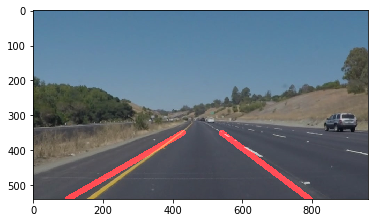

In [35]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import numpy
import math

img = "solidYellowCurve.jpg"

#reading in an image
image = mpimg.imread('test_images/' + img)

#converting image to grayscale
gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 200
high_threshold = 255
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# defining region of interest
shape = numpy.array([ [160, 540], [430, 350], [540, 350], [900,540] ], numpy.int32)
roi = region_of_interest(masked_edges, [shape])

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 150    # maximum gap in pixels between connectable line segments

#Call Hough Lines algorithm
hough = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)

result = weighted_img(hough, image, α=0.8, β=1., λ=0.)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(result, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy

In [37]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images_output directory.

    #converting image to grayscale
    gray = grayscale(image)

    #defining region of interest
    #vertices = numpy.array([ [140, 540], [480,300], [880,540] ], numpy.int32)
    #roi = region_of_interest(gray, [vertices])g

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 200
    high_threshold = 250
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments

    vertices = numpy.array([ [140, 540], [480,300], [880,540] ], numpy.int32)
    roi = region_of_interest(masked_edges, [vertices])
    
    #Call Hough Lines algorithm
    hough = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)

    result = weighted_img(hough, image, α=0.8, β=1., λ=0.)

    return result

Let's try the one with the solid white lane on the right first ...

In [38]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

123 789
0.617838680703 -0.76243753597
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

123 789
0.617838680703 -0.76243753597
125 794
0.622869021072 -0.746387432013
125 817
0.62148856096 -0.68473623836


  1%|█                                                                                 | 3/222 [00:00<00:07, 29.62it/s]

120 808
0.611499477993 -0.708662250858
119 800
0.61052144441 -0.728982580804
116 809
0.604423139514 -0.704549771408
108 810
0.588543428402 -0.702644489221


  3%|██▌                                                                               | 7/222 [00:00<00:07, 30.28it/s]

96 801
0.568200068238 -0.726019869252
129 802
0.629191227077 -0.722979843028
131 799
0.634329118269 -0.732673523664
129 811
0.630429401433 -0.700303408757
129 806
0.631188070055 -0.712726934044


  5%|████▍                                                                            | 12/222 [00:00<00:06, 33.16it/s]

129 803
0.629448852301 -0.721597162544
126 803
0.624052648688 -0.72215470049
145 798
0.666270684991 -0.735383759079
95 804
0.566825500119 -0.71860708486


  7%|█████▊                                                                           | 16/222 [00:00<00:06, 33.95it/s]

136 796
0.644264323939 -0.740472766385
127 804
0.626528497659 -0.719665952248
120 819
0.612828284141 -0.680931777643
135 803
0.643172199778 -0.720716892649


  9%|███████▎                                                                         | 20/222 [00:00<00:05, 34.88it/s]

114 813
0.599726311531 -0.694252013058
140 818
0.654320061014 -0.683356903718
127 805
0.625670922484 -0.716111951984
137 805
0.648318436278 -0.71693188577
122 804
0.615825954665 -0.71821785022


 11%|█████████                                                                        | 25/222 [00:00<00:05, 36.41it/s]

148 802
0.672911675013 -0.724782076499
117 805
0.606732466297 -0.714334803361
131 802
0.634844981708 -0.723028291649
140 802
0.654340389318 -0.723416392549


 13%|██████████▌                                                                      | 29/222 [00:00<00:05, 35.97it/s]

127 801
0.625779795811 -0.725755867832
126 802
0.623526212977 -0.722808932261
136 802
0.645713571371 -0.724473480342
124 801
0.619495119716 -0.726754627454


 15%|████████████                                                                     | 33/222 [00:00<00:05, 36.66it/s]

122 794
0.615571865797 -0.745816198393
116 808
0.603409182151 -0.707067834727
157 798
0.694864972767 -0.735439074099
129 816
0.630878552551 -0.687505757466


 17%|█████████████▌                                                                   | 37/222 [00:01<00:05, 35.85it/s]

125 800
0.621074408871 -0.728779057883
158 800
0.698177854794 -0.730404452562
130 806
0.631783850995 -0.713732612315
143 805
0.661388485808 -0.714982710868


 18%|██████████████▉                                                                  | 41/222 [00:01<00:05, 35.88it/s]

139 799
0.651629809052 -0.731659083873
126 796
0.623257553267 -0.740286065089
154 801
0.687626454747 -0.726388974013
161 799
0.70441631664 -0.732530752577


 20%|████████████████▍                                                                | 45/222 [00:01<00:05, 35.23it/s]

137 798
0.646657581533 -0.73601245207
129 798
0.630793218686 -0.733721500835
133 806
0.637888468453 -0.71334621139
125 796
0.622938939148 -0.740381044925


 22%|█████████████████▉                                                               | 49/222 [00:01<00:06, 27.02it/s]

134 792
0.640145560338 -0.75321098949
118 797
0.60746923668 -0.73915636721
135 799
0.643156828762 -0.731593573941


 23%|██████████████████▉                                                              | 52/222 [00:01<00:06, 27.83it/s]

139 795
0.65268644167 -0.742802085276
153 808
0.684594083612 -0.707448168135
131 808
0.634509468188 -0.708719912049


 25%|████████████████████                                                             | 55/222 [00:01<00:08, 19.18it/s]

120 809
0.611799235616 -0.704762850857
130 813
0.631417379984 -0.694016648055
152 815
0.683298604551 -0.689230230632


 26%|█████████████████████▏                                                           | 58/222 [00:01<00:08, 20.44it/s]

136 813
0.645793345418 -0.694405153751
128 804
0.627142777359 -0.718308363922
125 817
0.622718214596 -0.683611999706


 27%|██████████████████████▎                                                          | 61/222 [00:02<00:08, 18.42it/s]

132 801
0.636098309496 -0.727868896971
151 810
0.679580544229 -0.701427881723
136 809
0.644551828931 -0.705443613288


 29%|███████████████████████▎                                                         | 64/222 [00:02<00:07, 20.48it/s]

135 810
0.643233656461 -0.703398046025
134 815
0.641643043488 -0.68986126083
147 805
0.669557582607 -0.7169051557


 30%|████████████████████████▍                                                        | 67/222 [00:02<00:08, 19.29it/s]

147 814
0.670971495403 -0.691879528723
129 807
0.630203143689 -0.709944371291
158 808
0.695988763201 -0.706403931723


 32%|█████████████████████████▌                                                       | 70/222 [00:02<00:07, 20.48it/s]

151 818
0.680368151716 -0.683182082096
133 826
0.638396977307 -0.66203284028
141 814
0.655279613745 -0.692196681703


 33%|██████████████████████████▋                                                      | 73/222 [00:02<00:07, 19.00it/s]

138 816
0.650374321928 -0.686097190397
137 809
0.648333828823 -0.704191082354
144 814
0.66249118859 -0.691694490056


 34%|███████████████████████████▋                                                     | 76/222 [00:02<00:07, 20.42it/s]

163 803
0.7097528577 -0.721976819616
152 822
0.683074465448 -0.672043012508
134 823
0.641587569986 -0.670995937796


 36%|████████████████████████████▊                                                    | 79/222 [00:03<00:07, 19.52it/s]

154 813
0.686493031525 -0.694629209275
165 818
0.716410104303 -0.681333450433
151 821
0.680731419404 -0.67376422921


 37%|█████████████████████████████▉                                                   | 82/222 [00:03<00:06, 20.33it/s]

151 821
0.67996780824 -0.676058408192
148 813
0.672836313887 -0.694296242763
149 819
0.676002884899 -0.679443861581


 38%|███████████████████████████████                                                  | 85/222 [00:03<00:06, 19.97it/s]

162 816
0.706851354519 -0.687992233307
153 814
0.685038327911 -0.692226838366
159 816
0.698932868292 -0.686247985741


 40%|████████████████████████████████                                                 | 88/222 [00:03<00:06, 21.84it/s]

156 819
0.693139505259 -0.680551835178
144 820
0.663867816476 -0.676858051799
139 821
0.650857875106 -0.675761919475


 41%|█████████████████████████████████▏                                               | 91/222 [00:03<00:06, 19.57it/s]

163 823
0.711049410833 -0.669309857513
153 818
0.685499213157 -0.681416705137
138 818
0.648522097771 -0.683280449451


 42%|██████████████████████████████████▎                                              | 94/222 [00:03<00:06, 20.83it/s]

149 821
0.674312661787 -0.674322782175
165 822
0.714425755762 -0.671650785071
161 816
0.705697814617 -0.688306506506


 44%|███████████████████████████████████▍                                             | 97/222 [00:03<00:06, 18.78it/s]

159 821
0.69898374104 -0.675075936287
153 809
0.684536591371 -0.706131332847
156 820
0.691474302236 -0.677208545443
139 830
0.652614256141 -0.653365599711


 45%|████████████████████████████████████▍                                           | 101/222 [00:04<00:05, 20.89it/s]

160 817
0.70216176182 -0.684180104693
149 818
0.674198406612 -0.682744566263
171 825
0.732776870613 -0.664484809029


 47%|█████████████████████████████████████▍                                          | 104/222 [00:04<00:05, 19.98it/s]

148 819
0.672420840287 -0.678683729435
129 825
0.630612641803 -0.665070830779
156 809
0.692199958428 -0.705151305786


 48%|██████████████████████████████████████▌                                         | 107/222 [00:04<00:05, 19.89it/s]

145 820
0.665574954197 -0.676857143757
145 819
0.665862823045 -0.680790328005
152 810
0.683260643746 -0.702534436076


 50%|███████████████████████████████████████▋                                        | 110/222 [00:04<00:05, 19.91it/s]

152 812
0.681342537664 -0.696826015471
142 813
0.657981631992 -0.694452700258
151 803
0.680643614327 -0.722051065349


 51%|████████████████████████████████████████▋                                       | 113/222 [00:04<00:05, 20.37it/s]

124 814
0.619860346583 -0.691007247095
139 808
0.651968663967 -0.706469374125
128 817
0.628220329546 -0.68584426869


 52%|█████████████████████████████████████████▊                                      | 116/222 [00:04<00:05, 19.84it/s]

142 814
0.658809556665 -0.693011617113
135 825
0.642882099617 -0.664956607712
150 829
0.678566330377 -0.655996826544


 54%|██████████████████████████████████████████▉                                     | 119/222 [00:04<00:04, 21.36it/s]

130 812
0.631743405387 -0.696663697404
141 805
0.656226039854 -0.714773206623
127 805
0.62636896345 -0.715604979475


 55%|███████████████████████████████████████████▉                                    | 122/222 [00:05<00:05, 18.97it/s]

141 817
0.655669999903 -0.685443710286
141 815
0.656076665058 -0.688600992223
141 811
0.655713130832 -0.700557483728
152 819
0.681589972743 -0.680174061522


 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:05<00:04, 21.88it/s]

133 815
0.63841977127 -0.689619030811
138 819
0.649047205274 -0.679417258814
144 816
0.662535809301 -0.687989266084


 58%|██████████████████████████████████████████████▍                                 | 129/222 [00:05<00:04, 19.75it/s]

147 821
0.670194050202 -0.675671976789
117 820
0.606342787908 -0.676851817083
128 823
0.627771454859 -0.670861104332
132 796
0.637024973945 -0.739306756652


 60%|███████████████████████████████████████████████▉                                | 133/222 [00:05<00:04, 19.92it/s]

139 809
0.650888520811 -0.706101999647
113 799
0.597852088554 -0.731457628876
148 807
0.672620925501 -0.710553810414


 61%|█████████████████████████████████████████████████                               | 136/222 [00:05<00:04, 20.38it/s]

122 811
0.615939539689 -0.699856858145
137 814
0.648093298561 -0.691693010285
114 807
0.600821501402 -0.709930416256


 63%|██████████████████████████████████████████████████                              | 139/222 [00:05<00:03, 21.38it/s]

133 806
0.638186149318 -0.712558065706
111 806
0.594751809974 -0.713325580155
119 802
0.610200347802 -0.72460885294


 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:06<00:04, 18.62it/s]

129 806
0.629882823304 -0.712503887946
134 809
0.641798027907 -0.706177074439
125 793
0.621969851756 -0.750471504278


 65%|████████████████████████████████████████████████████▎                           | 145/222 [00:06<00:04, 18.61it/s]

120 810
0.611192577708 -0.703628315501
123 801
0.618772698722 -0.726443130104


 66%|████████████████████████████████████████████████████▉                           | 147/222 [00:06<00:04, 18.57it/s]

138 813
0.649477000455 -0.694098269307
107 799
0.586587350191 -0.732191836695
124 803
0.619255528714 -0.722225828792


 68%|██████████████████████████████████████████████████████                          | 150/222 [00:06<00:03, 20.23it/s]

132 803
0.636305997469 -0.72021563832
121 803
0.614714650267 -0.721786139435
127 801
0.626307310611 -0.725789879398


 69%|███████████████████████████████████████████████████████▏                        | 153/222 [00:06<00:03, 18.81it/s]

137 810
0.647051875362 -0.70213528417
112 793
0.59573562781 -0.74938792861
103 797
0.579672265908 -0.737006995518


 70%|████████████████████████████████████████████████████████▏                       | 156/222 [00:06<00:03, 19.63it/s]

94 804
0.564731566476 -0.718154094518
117 786
0.605240534203 -0.77121285193
118 804
0.607142892966 -0.719264162302


 72%|█████████████████████████████████████████████████████████▎                      | 159/222 [00:07<00:03, 17.51it/s]

106 805
0.585048147765 -0.714373166268
84 796
0.548064420206 -0.740777777112


 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:07<00:03, 15.54it/s]

75 781
0.534898329864 -0.78542655165
117 794
0.606588842948 -0.746033827119
119 789
0.609099987212 -0.760105116437


 74%|███████████████████████████████████████████████████████████                     | 164/222 [00:07<00:03, 17.46it/s]

113 784
0.598221558563 -0.775536971249
114 793
0.599832996398 -0.750435447777
103 796
0.580032899688 -0.740771387848


 75%|████████████████████████████████████████████████████████████▏                   | 167/222 [00:07<00:03, 17.29it/s]

111 791
0.595453547605 -0.755107985379
121 789
0.614773608523 -0.762197533109


 76%|████████████████████████████████████████████████████████████▉                   | 169/222 [00:07<00:02, 18.01it/s]

118 784
0.608166573463 -0.778598622522
86 785
0.552030328631 -0.774960805495


 77%|█████████████████████████████████████████████████████████████▌                  | 171/222 [00:07<00:02, 18.24it/s]

113 783
0.598204276131 -0.781394937879
109 772
0.591257291133 -0.818756919709


 78%|██████████████████████████████████████████████████████████████▎                 | 173/222 [00:07<00:03, 16.09it/s]

105 780
0.583650102291 -0.788940275564
111 784
0.594856352332 -0.777142923455


 79%|███████████████████████████████████████████████████████████████                 | 175/222 [00:08<00:02, 16.61it/s]

106 789
0.585988109581 -0.761635874087
111 785
0.593826591286 -0.773353671093
100 780
0.574291544256 -0.791481217906


 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:08<00:02, 17.10it/s]

108 780
0.589764236275 -0.790262138914
140 788
0.654865386542 -0.765745103042
116 777
0.605039081963 -0.801537797615


 82%|█████████████████████████████████████████████████████████████████▏              | 181/222 [00:08<00:02, 18.46it/s]

106 770
0.586026197719 -0.825297129417
99 776
0.573001363125 -0.804960751614


 82%|█████████████████████████████████████████████████████████████████▉              | 183/222 [00:08<00:02, 17.77it/s]

114 779
0.600085431706 -0.792105894021
135 774
0.642270987153 -0.810940956404


 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:08<00:02, 14.12it/s]

128 790
0.627430503376 -0.759686626186
109 780
0.591798138265 -0.788464261297
106 774
0.586206896552 -0.809163191746


 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:08<00:02, 16.15it/s]

111 779
0.594876031121 -0.791954670864


 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:08<00:01, 16.70it/s]

94 795
0.564205395232 -0.742723580348
116 786
0.603662143459 -0.772304162879
91 777
0.559660794809 -0.799619969075


 87%|█████████████████████████████████████████████████████████████████████▌          | 193/222 [00:09<00:01, 17.71it/s]

59 777
0.511367214201 -0.799931755307
38 789
0.48417637797 -0.760406867316
90 784
0.558474428726 -0.776980646215


 88%|██████████████████████████████████████████████████████████████████████▋         | 196/222 [00:09<00:01, 19.07it/s]

81 771
0.543013944893 -0.822458219309
78 779
0.538266873948 -0.793459394197
115 773
0.601344018182 -0.814645836835


 90%|███████████████████████████████████████████████████████████████████████▋        | 199/222 [00:09<00:01, 18.85it/s]

112 775
0.595760579212 -0.805455423284
120 779
0.612804414787 -0.79423109961
121 774
0.612995614829 -0.810132949095


 91%|████████████████████████████████████████████████████████████████████████▊       | 202/222 [00:09<00:00, 21.11it/s]

98 775
0.571056387156 -0.807805483894
115 777
0.601700781733 -0.79859693311
99 776
0.572432487704 -0.801819661699


 92%|█████████████████████████████████████████████████████████████████████████▊      | 205/222 [00:09<00:00, 19.61it/s]

108 770
0.5892032104 -0.825586010703
101 767
0.576930022458 -0.835323087039
106 775
0.58532359583 -0.808004222067


 94%|██████████████████████████████████████████████████████████████████████████▉     | 208/222 [00:09<00:00, 20.43it/s]

102 784
0.57839466813 -0.778348172901
102 778
0.578947617769 -0.797930668076
101 780
0.575853932391 -0.789186366369


 95%|████████████████████████████████████████████████████████████████████████████    | 211/222 [00:09<00:00, 19.68it/s]

101 786
0.576369197495 -0.769849527234
101 784
0.576906929585 -0.776243880728
117 783
0.605719110793 -0.780511877122
88 785
0.553947076242 -0.77429365094


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:10<00:00, 21.59it/s]

92 787
0.562104281883 -0.766340619587
83 780
0.547214480894 -0.790532265809
100 779
0.574161782315 -0.792770050317


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:10<00:00, 20.59it/s]

89 787
0.555570284366 -0.768316619689
112 788
0.59695131122 -0.76458575543
130 790
0.632569569742 -0.758042866492


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:10<00:00, 21.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [40]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

150 833
0.677302225993 -0.647938950891
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

150 833
0.677302225993 -0.647938950891
156 828
0.690918985433 -0.657598045624
152 830
0.682319716153 -0.654244580975


  0%|▎                                                                                 | 3/682 [00:00<00:22, 29.62it/s]

155 819
0.690260087522 -0.680801468673
157 802
0.694107990029 -0.722558217957
152 828
0.682146839014 -0.657903386024
148 818
0.672737677516 -0.682843084797


  1%|▊                                                                                 | 7/682 [00:00<00:21, 30.98it/s]

145 824
0.665695391791 -0.667525321919
145 830
0.665638509132 -0.653283489571
150 827
0.677296721959 -0.660178602316
158 824
0.697767441326 -0.667144372369


  2%|█▎                                                                               | 11/682 [00:00<00:21, 31.78it/s]

140 815
0.65397954286 -0.689972906113
137 823
0.64841222481 -0.67034066547
131 820
0.634745795501 -0.677399293188
132 821
0.636279549101 -0.675897421444


  2%|█▊                                                                               | 15/682 [00:00<00:20, 32.28it/s]

152 807
0.681548145178 -0.709184530535
134 815
0.639784241307 -0.690715310897
132 806
0.636571247387 -0.713461220893
132 813
0.637455950228 -0.695572011713


  3%|██▎                                                                              | 19/682 [00:00<00:21, 31.04it/s]

140 809
0.653232923289 -0.705689705892
131 788
0.634861892481 -0.763804529969
131 816
0.633602065458 -0.686001756027


  3%|██▌                                                                              | 22/682 [00:00<00:23, 27.71it/s]

124 805
0.619859735727 -0.714715818227
129 808
0.63056118632 -0.707232949747
138 808
0.649112149928 -0.706516688123
134 797
0.640394540991 -0.736637698167


  4%|███                                                                              | 26/682 [00:00<00:21, 30.30it/s]

97 788
0.569070175033 -0.76478294674
101 795
0.577286448852 -0.743660972314
128 801
0.628556197445 -0.726413946507
126 794
0.6237976901 -0.74548980827


  4%|███▌                                                                             | 30/682 [00:00<00:20, 31.35it/s]

116 804
0.603204657662 -0.71707486275
125 804
0.621209791552 -0.718429882811
125 806
0.621079762232 -0.711881420665
123 808
0.617587287546 -0.706541600064


  5%|████                                                                             | 34/682 [00:01<00:20, 31.82it/s]

114 786
0.600916453372 -0.770901021356
130 790
0.631653235555 -0.759712740087
119 795
0.609853969078 -0.7445234523
121 810
0.613670457914 -0.701874779559


  6%|████▌                                                                            | 38/682 [00:01<00:21, 29.58it/s]

117 776
0.606347983696 -0.802318916987
145 792
0.666666666667 -0.752217898649
147 794
0.67111180739 -0.74625448286
114 792
0.60114754823 -0.751374529082


  6%|████▉                                                                            | 42/682 [00:01<00:20, 30.66it/s]

122 803
0.614968895553 -0.719792634257
117 792
0.605950233747 -0.753623762629
124 783
0.619898803496 -0.780566015857
126 792
0.623307269247 -0.753290780921


  7%|█████▍                                                                           | 46/682 [00:01<00:20, 31.32it/s]

116 785
0.60321167855 -0.774890863676
119 807
0.610397125657 -0.71119903456
128 817
0.627363634035 -0.683522235105
117 804
0.605107417891 -0.717486785909


  7%|█████▉                                                                           | 50/682 [00:01<00:24, 25.91it/s]

107 802
0.58764968274 -0.725165026446
132 803
0.63617110749 -0.721282135271
129 819
0.630409375987 -0.679338174497


  8%|██████▎                                                                          | 53/682 [00:01<00:25, 24.91it/s]

126 792
0.624887705465 -0.751868255571
130 788
0.631895901119 -0.765058238608
119 803
0.609301389104 -0.719796294256


  8%|██████▋                                                                          | 56/682 [00:02<00:36, 17.31it/s]

116 813
0.604831667664 -0.694642645023
130 797
0.63241430042 -0.737383557699
117 793
0.60670643025 -0.749793834238


  9%|███████                                                                          | 59/682 [00:02<00:33, 18.70it/s]

125 805
0.622897059748 -0.714826062348
129 798
0.63082578957 -0.73428942571
131 787
0.634171781545 -0.768730359904


  9%|███████▎                                                                         | 62/682 [00:02<00:40, 15.41it/s]

124 803
0.619911762617 -0.721996659113
129 796
0.631009589931 -0.74017351606


  9%|███████▌                                                                         | 64/682 [00:02<00:38, 16.25it/s]

141 799
0.656957373659 -0.733342131375
144 802
0.662289541704 -0.724202299676


 10%|███████▊                                                                         | 66/682 [00:02<00:39, 15.70it/s]

126 807
0.62476158192 -0.709058893051
120 799
0.611934435395 -0.733142170968


 10%|████████                                                                         | 68/682 [00:02<00:41, 14.63it/s]

134 795
0.640219837876 -0.743824202377
134 810
0.641364435679 -0.701919790913


 10%|████████▎                                                                        | 70/682 [00:03<00:44, 13.62it/s]

140 799
0.653009078964 -0.732626048832
125 810
0.621164561551 -0.701449240215
133 801
0.639350206285 -0.725932848037


 11%|████████▋                                                                        | 73/682 [00:03<00:44, 13.80it/s]

138 805
0.649435209111 -0.714328400775
141 789
0.657059297207 -0.76184187494


 11%|████████▉                                                                        | 75/682 [00:03<00:44, 13.62it/s]

124 802
0.620335784172 -0.722471929668
129 801
0.630713273029 -0.72529590217


 11%|█████████▏                                                                       | 77/682 [00:03<00:40, 15.02it/s]

132 816
0.636660746153 -0.687485603107
147 800
0.671217091114 -0.728179020368


 12%|█████████▍                                                                       | 79/682 [00:03<00:40, 14.91it/s]

146 779
0.667594455264 -0.792280846364
143 814
0.6609273542 -0.69154409346


 12%|█████████▌                                                                       | 81/682 [00:03<00:42, 14.17it/s]

140 804
0.654619624307 -0.717713797701
141 787
0.6556004169 -0.768711349385


 12%|█████████▊                                                                       | 83/682 [00:03<00:38, 15.41it/s]

138 794
0.649990900767 -0.74655080586
132 794
0.637176481981 -0.745796727139
138 805
0.649573181667 -0.715138285438


 13%|██████████▏                                                                      | 86/682 [00:04<00:40, 14.86it/s]

133 817
0.639092430836 -0.684877995955
129 799
0.630812532111 -0.731239677073
134 792
0.640842491811 -0.752841603991


 13%|██████████▌                                                                      | 89/682 [00:04<00:34, 17.39it/s]

126 797
0.624915907444 -0.738306470679
129 812
0.629291757571 -0.696095004396
147 807
0.670122750849 -0.709638853688


 13%|██████████▉                                                                      | 92/682 [00:04<00:32, 18.35it/s]

132 792
0.637097137705 -0.752619440169
134 791
0.641467823443 -0.75633176578


 14%|███████████▏                                                                     | 94/682 [00:04<00:33, 17.38it/s]

141 818
0.655485444577 -0.681358968633
132 805
0.637439262032 -0.715240640637


 14%|███████████▍                                                                     | 96/682 [00:04<00:34, 17.05it/s]

144 796
0.663499820507 -0.742101118835
140 796
0.65309573063 -0.741353688486
140 821
0.654380718303 -0.675288621494


 15%|███████████▊                                                                     | 99/682 [00:04<00:33, 17.33it/s]

128 812
0.627652595523 -0.696342740456
145 813
0.665966424902 -0.695627019531


 15%|███████████▊                                                                    | 101/682 [00:04<00:35, 16.56it/s]

121 806
0.613477319154 -0.713121777412
125 820
0.620961249328 -0.677339492589
148 816
0.671620240031 -0.687672879327


 15%|████████████▏                                                                   | 104/682 [00:05<00:30, 18.66it/s]

145 816
0.666160492746 -0.686872415859
136 782
0.646119709444 -0.783184590312


 16%|████████████▍                                                                   | 106/682 [00:05<00:35, 16.28it/s]

134 795
0.640128645268 -0.742501440562
132 821
0.635616583216 -0.676047758966
131 815
0.634469347333 -0.688520095099


 16%|████████████▊                                                                   | 109/682 [00:05<00:31, 18.27it/s]

136 805
0.644977543268 -0.715381706425
137 787
0.647656559198 -0.766976095942
132 804
0.636913175529 -0.718394630984


 16%|█████████████▏                                                                  | 112/682 [00:05<00:33, 17.22it/s]

129 813
0.631209540004 -0.69421832221
140 805
0.653682751861 -0.716408699799
139 809
0.650711030259 -0.705954339624


 17%|█████████████▍                                                                  | 115/682 [00:05<00:30, 18.32it/s]

138 813
0.648805825848 -0.693567157088
137 824
0.646920292648 -0.668511534706
124 767
0.620408651202 -0.833800510815


 17%|█████████████▊                                                                  | 118/682 [00:05<00:30, 18.74it/s]

128 806
0.627242861953 -0.711833832962
133 810
0.638676763488 -0.703353053965


 18%|██████████████                                                                  | 120/682 [00:05<00:30, 18.45it/s]

135 805
0.643130837193 -0.715516536991
137 802
0.647007228996 -0.725162402818


 18%|██████████████▎                                                                 | 122/682 [00:06<00:31, 18.06it/s]

131 820
0.633417896195 -0.678463274908
130 832
0.631996595435 -0.649778687838
139 816
0.652764288206 -0.687907864109


 18%|██████████████▋                                                                 | 125/682 [00:06<00:29, 19.19it/s]

134 810
0.640004889499 -0.702682547187
127 791
0.62675034416 -0.756795217392


 19%|██████████████▉                                                                 | 127/682 [00:06<00:30, 18.09it/s]

126 789
0.624246167453 -0.762852736889
139 808
0.650799540711 -0.707078553217


 19%|███████████████▏                                                                | 129/682 [00:06<00:30, 17.91it/s]

132 816
0.636232881149 -0.687928377951
133 796
0.637962171239 -0.739792758047


 19%|███████████████▎                                                                | 131/682 [00:06<00:29, 18.42it/s]

138 816
0.649007075344 -0.687453200182
125 810
0.622719429824 -0.702791395054


 20%|███████████████▌                                                                | 133/682 [00:06<00:29, 18.54it/s]

130 802
0.632044566639 -0.723045363403
133 803
0.63888558298 -0.720993911923
130 812
0.631271286876 -0.698209237961


 20%|███████████████▉                                                                | 136/682 [00:06<00:27, 19.69it/s]

131 802
0.635120444674 -0.725136303571
134 791
0.64164391471 -0.756459900208
142 817
0.658046871246 -0.68574973807


 20%|████████████████▎                                                               | 139/682 [00:06<00:29, 18.15it/s]

138 808
0.648701734213 -0.707571847348
117 802
0.60564070442 -0.72333510053
135 788
0.643161339006 -0.765495618588


 21%|████████████████▋                                                               | 142/682 [00:07<00:27, 19.61it/s]

132 802
0.637197542516 -0.724186750754
126 809
0.623466717992 -0.70387354929
130 803
0.631370394754 -0.722199799744


 21%|█████████████████                                                               | 145/682 [00:07<00:29, 17.93it/s]

126 811
0.6243925506 -0.698911566202
127 813
0.625757143317 -0.694168728783
135 814
0.642499094798 -0.692610891149


 22%|█████████████████▎                                                              | 148/682 [00:07<00:26, 19.82it/s]

129 831
0.629523391784 -0.651119644518
132 818
0.635609735603 -0.681114888693
123 818
0.617941147386 -0.683236477827


 22%|█████████████████▋                                                              | 151/682 [00:07<00:28, 18.36it/s]

119 814
0.609598505993 -0.69139917749
132 804
0.636211971246 -0.718699496189
138 813
0.649439966776 -0.694514254277


 23%|██████████████████                                                              | 154/682 [00:07<00:25, 20.55it/s]

145 814
0.665816468514 -0.691845477127
121 796
0.613169029651 -0.739395193681
115 803
0.60199763097 -0.719998488489


 23%|██████████████████▍                                                             | 157/682 [00:07<00:27, 19.30it/s]

110 819
0.593469730891 -0.678723896763
121 814
0.614452435619 -0.692843904477
116 816
0.604690213738 -0.687577403692


 23%|██████████████████▊                                                             | 160/682 [00:08<00:27, 18.72it/s]

112 814
0.595737930583 -0.69214347708
113 814
0.598907598642 -0.693273071536
116 795
0.604534559536 -0.743051305066


 24%|███████████████████                                                             | 163/682 [00:08<00:25, 20.65it/s]

98 800
0.571266845266 -0.730290838411
108 791
0.589648170063 -0.755830597341
99 803
0.572628364095 -0.719920401012


 24%|███████████████████▍                                                            | 166/682 [00:08<00:26, 19.14it/s]

114 811
0.60063969468 -0.699246273761
120 813
0.611315313071 -0.694793012152
106 807
0.585173244748 -0.709243275165


 25%|███████████████████▊                                                            | 169/682 [00:08<00:28, 18.14it/s]

91 801
0.560288285534 -0.726242250802
116 795
0.604320123161 -0.745024644851
105 788
0.584354110282 -0.764027399077


 25%|████████████████████▏                                                           | 172/682 [00:08<00:26, 19.30it/s]

100 798
0.575118520352 -0.735203890081
112 788
0.596972514069 -0.7642078526
95 801
0.566929757805 -0.727659079841


 26%|████████████████████▌                                                           | 175/682 [00:08<00:27, 18.55it/s]

107 789
0.587776195866 -0.761966120877
108 787
0.589677376308 -0.768104545464
92 799
0.560489570521 -0.733154014431


 26%|████████████████████▉                                                           | 178/682 [00:09<00:26, 19.09it/s]

99 775
0.573558366411 -0.806488674047
79 779
0.540309571225 -0.791788595412


 26%|█████████████████████                                                           | 180/682 [00:09<00:30, 16.30it/s]

95 789
0.566447404158 -0.762979456572
96 792
0.567581225266 -0.752210963398
88 763
0.555086556565 -0.848988599271


 27%|█████████████████████▍                                                          | 183/682 [00:09<00:27, 17.96it/s]

102 786
0.578980647332 -0.771225783939
101 796
0.576769556078 -0.740411020054
110 796
0.592149997855 -0.741873140201


 27%|█████████████████████▊                                                          | 186/682 [00:09<00:25, 19.65it/s]

87 778
0.553722811959 -0.797416154914
91 794
0.560118278313 -0.745439602417
102 778
0.578590393599 -0.79572881913


 28%|██████████████████████▏                                                         | 189/682 [00:09<00:25, 19.54it/s]

100 776
0.575338280775 -0.804193071773
80 783
0.542093291791 -0.780855767798
88 764
0.555053467821 -0.846075351239


 28%|██████████████████████▌                                                         | 192/682 [00:09<00:27, 18.03it/s]

87 797
0.55308357345 -0.737657557871
90 793
0.557888227123 -0.748296666058
98 786
0.571436600209 -0.770702166615


 29%|██████████████████████▊                                                         | 195/682 [00:09<00:24, 19.70it/s]

97 785
0.56973606076 -0.774720354143
79 792
0.540168576914 -0.751794486218
92 784
0.56096289959 -0.776650149424


 29%|███████████████████████▏                                                        | 198/682 [00:10<00:26, 18.46it/s]

96 772
0.568760633867 -0.818595239336
93 792
0.56241651209 -0.752409753732
107 792
0.587737801807 -0.753493394105


 29%|███████████████████████▌                                                        | 201/682 [00:10<00:23, 20.34it/s]

108 819
0.589362255074 -0.679374832908
100 788
0.574506238415 -0.763335378714
90 805
0.558115867903 -0.716654420943


 30%|███████████████████████▉                                                        | 204/682 [00:10<00:26, 17.84it/s]

119 807
0.610353952936 -0.71005841858
99 793
0.572996701368 -0.748642673107
106 775
0.584940582868 -0.807587373427


 30%|████████████████████████▎                                                       | 207/682 [00:10<00:25, 18.32it/s]

97 780
0.569199104421 -0.789659201841
97 781
0.56911153637 -0.786984827548
104 779
0.581095281306 -0.794091230785


 31%|████████████████████████▋                                                       | 210/682 [00:10<00:24, 19.25it/s]

100 815
0.574069174306 -0.690653699263
117 782
0.606615131556 -0.785013517224
113 803
0.598643386592 -0.721175275797


 31%|████████████████████████▉                                                       | 213/682 [00:10<00:24, 19.30it/s]

121 784
0.613175436708 -0.775966059521
115 794
0.602207449252 -0.74780265184
124 802
0.620027445649 -0.723040376479


 32%|█████████████████████████▎                                                      | 216/682 [00:11<00:25, 18.11it/s]

97 819
0.569926926103 -0.679329371085
100 819
0.575533563769 -0.680576085954


 32%|█████████████████████████▌                                                      | 218/682 [00:11<00:26, 17.78it/s]

129 799
0.630128276318 -0.733405227711
102 803
0.578171332778 -0.721309767072
109 802
0.59140087119 -0.723753762545


 32%|█████████████████████████▉                                                      | 221/682 [00:11<00:23, 19.27it/s]

114 798
0.600736059315 -0.736410984932
109 819
0.591783540138 -0.68037041826


 33%|██████████████████████████▏                                                     | 223/682 [00:11<00:24, 18.86it/s]

131 827
0.634613637549 -0.660518858595
131 811
0.633403751034 -0.698963495756


 33%|██████████████████████████▍                                                     | 225/682 [00:11<00:26, 17.55it/s]

118 793
0.607501654658 -0.748999257546
116 805
0.604488239356 -0.716449292493
125 796
0.621270797162 -0.740935890655


 33%|██████████████████████████▋                                                     | 228/682 [00:11<00:23, 19.53it/s]

131 804
0.63448055058 -0.717261767541
111 796
0.594542958412 -0.739534919215
113 805
0.59846345012 -0.716726190006


 34%|███████████████████████████                                                     | 231/682 [00:11<00:25, 17.51it/s]

125 801
0.622346250322 -0.726064237757
118 804
0.607490149791 -0.718392690602
117 807
0.606253812742 -0.709241790287


 34%|███████████████████████████▍                                                    | 234/682 [00:11<00:23, 19.30it/s]

125 807
0.62207404881 -0.708958753904
119 805
0.609524888251 -0.714682109671
117 801
0.605460411434 -0.727548651806


 35%|███████████████████████████▊                                                    | 237/682 [00:12<00:24, 18.24it/s]

118 812
0.608911695199 -0.697310809911
111 820
0.595046643746 -0.676579549305
128 808
0.627800546474 -0.706891536902


 35%|████████████████████████████▏                                                   | 240/682 [00:12<00:22, 19.76it/s]

138 813
0.650214497043 -0.693532256482
125 794
0.621323427477 -0.745122156558
95 782
0.56588425962 -0.783579090399


 36%|████████████████████████████▌                                                   | 243/682 [00:12<00:20, 21.12it/s]

105 808
0.584505840448 -0.706427815423
116 818
0.604239307783 -0.682184404126
117 809
0.605955338486 -0.705707488979


 36%|████████████████████████████▊                                                   | 246/682 [00:12<00:22, 19.31it/s]

111 801
0.595190993811 -0.72531223264
122 796
0.616466047202 -0.741941233305
141 804
0.656052734187 -0.71743252311


 37%|█████████████████████████████▏                                                  | 249/682 [00:12<00:23, 18.11it/s]

114 812
0.60041761112 -0.696364514756
137 815
0.648063324453 -0.688485468222


 37%|█████████████████████████████▍                                                  | 251/682 [00:12<00:30, 14.18it/s]

128 807
0.627263756065 -0.710284373411
127 810
0.62676399274 -0.702245661385


 37%|█████████████████████████████▋                                                  | 253/682 [00:13<00:27, 15.42it/s]

134 796
0.640497809213 -0.739825354154
137 802
0.648338167041 -0.72268797225


 37%|█████████████████████████████▉                                                  | 255/682 [00:13<00:27, 15.61it/s]

137 822
0.64668609213 -0.671769395286
123 812
0.618489490757 -0.697953965473


 38%|██████████████████████████████▏                                                 | 257/682 [00:13<00:29, 14.33it/s]

128 807
0.628924567911 -0.710377415648
132 785
0.636524199337 -0.7732177313
141 807
0.657370640753 -0.711538333981


 38%|██████████████████████████████▍                                                 | 260/682 [00:13<00:25, 16.84it/s]

132 800
0.636032137921 -0.728565871699
122 824
0.616415350771 -0.668503798272
115 799
0.602404458562 -0.732087666537


 39%|██████████████████████████████▊                                                 | 263/682 [00:13<00:24, 16.91it/s]

129 799
0.630949974026 -0.732168238937
128 802
0.627981027668 -0.724751784312
138 813
0.649517708294 -0.694334948143


 39%|███████████████████████████████▏                                                | 266/682 [00:13<00:22, 18.65it/s]

124 807
0.619800613262 -0.710778273013
101 811
0.576279999754 -0.70027426188
110 812
0.593096222744 -0.697932647113


 39%|███████████████████████████████▌                                                | 269/682 [00:13<00:22, 18.63it/s]

115 828
0.602626179935 -0.659417003209
121 808
0.614761370054 -0.707125705607


 40%|███████████████████████████████▊                                                | 271/682 [00:14<00:26, 15.58it/s]

122 784
0.615109858045 -0.77570959968
105 828
0.582985934246 -0.658985611864


 40%|████████████████████████████████                                                | 273/682 [00:14<00:24, 16.51it/s]

105 820
0.583705361296 -0.678499808238
111 827
0.594882585271 -0.66049109182
107 817
0.587657583141 -0.684246281088
106 821
0.585752661726 -0.674412750369


 41%|████████████████████████████████▍                                               | 277/682 [00:14<00:22, 17.90it/s]

107 811
0.587761021552 -0.698941766717
102 819
0.579063033624 -0.680151295086


 41%|████████████████████████████████▋                                               | 279/682 [00:14<00:22, 18.27it/s]

93 799
0.562214887262 -0.731943698212
114 825
0.599759045296 -0.664650843067


 41%|████████████████████████████████▉                                               | 281/682 [00:14<00:22, 17.69it/s]

122 810
0.615816686151 -0.702554680343
103 797
0.580254813724 -0.738746580074
98 810
0.571590044106 -0.703420156052


 42%|█████████████████████████████████▎                                              | 284/682 [00:14<00:19, 20.08it/s]

89 805
0.556809108922 -0.716495334368
104 812
0.581757455684 -0.69674362466
130 810
0.632886065057 -0.702247596664


 42%|█████████████████████████████████▋                                              | 287/682 [00:14<00:23, 17.03it/s]

116 813
0.603360038416 -0.693683981545
122 841
0.615589198681 -0.630245141925
115 807
0.601917477916 -0.709977869487


 43%|██████████████████████████████████                                              | 290/682 [00:15<00:20, 18.75it/s]

130 812
0.63323408764 -0.696233958917
132 833
0.6365328334 -0.647410634868
106 813
0.584624821037 -0.694660779691


 43%|██████████████████████████████████▎                                             | 293/682 [00:15<00:20, 19.43it/s]

125 775
0.622484357383 -0.806171268992
122 805
0.615599952078 -0.715573557076
130 798
0.631809205294 -0.735894935806


 43%|██████████████████████████████████▋                                             | 296/682 [00:15<00:20, 18.88it/s]

130 809
0.63327717607 -0.705899047351
121 782
0.614540037769 -0.783579544845
129 807
0.629150310214 -0.710782336036


 44%|███████████████████████████████████                                             | 299/682 [00:15<00:20, 18.37it/s]

132 809
0.636351082934 -0.705109858507
124 823
0.620553508973 -0.670191533813


 44%|███████████████████████████████████▎                                            | 301/682 [00:15<00:22, 17.17it/s]

111 811
0.595121275654 -0.700738913248
126 815
0.624520631548 -0.689243889428
136 791
0.645578342835 -0.756744324098


 45%|███████████████████████████████████▋                                            | 304/682 [00:15<00:19, 19.15it/s]

126 803
0.623528592476 -0.719979004883
121 822
0.614685795754 -0.672161460669
126 784
0.623731688157 -0.776567750906


 45%|████████████████████████████████████                                            | 307/682 [00:16<00:22, 16.89it/s]

119 806
0.609104595261 -0.711837694268
129 804
0.629205018395 -0.718131293421
125 814
0.62146035611 -0.693139686775


 45%|████████████████████████████████████▎                                           | 310/682 [00:16<00:19, 19.24it/s]

131 810
0.633658757131 -0.703326002106
127 812
0.62684777647 -0.696027112413
101 790
0.576008954859 -0.75720935123


 46%|████████████████████████████████████▋                                           | 313/682 [00:16<00:20, 18.24it/s]

123 812
0.618814267067 -0.696286777041
114 803
0.600683824591 -0.720385125225
134 798
0.640697847238 -0.733672369107


 46%|█████████████████████████████████████                                           | 316/682 [00:16<00:18, 20.28it/s]

127 804
0.625002630986 -0.71726760377
116 817
0.604480148382 -0.685767614845
112 791
0.597349078891 -0.754548972247


 47%|█████████████████████████████████████▍                                          | 319/682 [00:16<00:18, 19.17it/s]

115 824
0.60173411421 -0.668910636348
112 819
0.597019516608 -0.680375597964
119 800
0.609883549779 -0.730406378832


 47%|█████████████████████████████████████▊                                          | 322/682 [00:16<00:18, 19.47it/s]

110 799
0.593710674449 -0.732463895054
117 828
0.605873178696 -0.659326096445
116 818
0.603669714685 -0.681031450691


 48%|██████████████████████████████████████                                          | 325/682 [00:17<00:22, 16.05it/s]

131 815
0.634465296262 -0.690788312684
119 814
0.609650928108 -0.691782760497
136 807
0.645807999653 -0.710575929771


 48%|██████████████████████████████████████▍                                         | 328/682 [00:17<00:20, 16.93it/s]

137 829
0.64734437786 -0.656115681276
136 811
0.644168301298 -0.70103624596
119 822
0.610621520299 -0.67206738038


 49%|██████████████████████████████████████▊                                         | 331/682 [00:17<00:20, 16.81it/s]

123 822
0.617609862186 -0.672452552382
137 799
0.646281393624 -0.733328169142
132 821
0.636737601804 -0.673820714966


 49%|███████████████████████████████████████▏                                        | 334/682 [00:17<00:18, 18.53it/s]

121 803
0.613850554109 -0.719714703582
131 815
0.634881222924 -0.688759103002
133 822
0.637673551534 -0.672908185659


 49%|███████████████████████████████████████▌                                        | 337/682 [00:17<00:18, 18.47it/s]

116 816
0.60427631754 -0.68807860693
124 827
0.619865229244 -0.660348921148
135 809
0.643053423488 -0.703946560943


 50%|███████████████████████████████████████▉                                        | 340/682 [00:17<00:17, 19.04it/s]

137 808
0.647140387872 -0.706630236298
128 796
0.628499842816 -0.740079441082
122 792
0.6162436351 -0.751928603988
130 825
0.631908165187 -0.666295993226


 50%|████████████████████████████████████████▎                                       | 344/682 [00:18<00:17, 18.78it/s]

134 822
0.641025664112 -0.67214479909
128 824
0.62891819358 -0.667486480202
120 807
0.61206483731 -0.709060900344


 51%|████████████████████████████████████████▋                                       | 347/682 [00:18<00:16, 20.71it/s]

121 822
0.613529344682 -0.67362341597
134 813
0.640792701934 -0.695419928044
131 811
0.634710971076 -0.69916417215


 51%|█████████████████████████████████████████                                       | 350/682 [00:18<00:17, 19.43it/s]

124 815
0.620248424483 -0.689816219982
119 820
0.610237035724 -0.676593329709
143 810
0.660206307275 -0.703113370981


 52%|█████████████████████████████████████████▍                                      | 353/682 [00:18<00:15, 21.35it/s]

133 815
0.637960678153 -0.690103623395
125 821
0.622377670708 -0.674306876832
117 825
0.605186162377 -0.665062198463


 52%|█████████████████████████████████████████▊                                      | 356/682 [00:18<00:15, 20.95it/s]

116 819
0.604523240108 -0.680933821889
115 815
0.602607003557 -0.690183599111
127 803
0.62604082879 -0.722215003836


 53%|██████████████████████████████████████████                                      | 359/682 [00:18<00:17, 18.60it/s]

124 829
0.619445438896 -0.65518992777
134 803
0.640172814027 -0.721077917698


 53%|██████████████████████████████████████████▎                                     | 361/682 [00:18<00:17, 18.82it/s]

128 811
0.627083120723 -0.699727702431
122 807
0.61598644669 -0.710066579718


 53%|██████████████████████████████████████████▌                                     | 363/682 [00:19<00:18, 16.91it/s]

111 812
0.59494420321 -0.695985503243
119 795
0.610413556582 -0.744804652984


 54%|██████████████████████████████████████████▊                                     | 365/682 [00:19<00:18, 17.12it/s]

128 806
0.627996289535 -0.712963584885
113 804
0.59822669352 -0.719610990865
114 791
0.599969964697 -0.755918400706


 54%|███████████████████████████████████████████▏                                    | 368/682 [00:19<00:16, 19.01it/s]

125 810
0.62118368999 -0.701582272342
121 800
0.614502715501 -0.729896287793
113 799
0.598368989288 -0.733125776064


 54%|███████████████████████████████████████████▌                                    | 371/682 [00:19<00:18, 16.48it/s]

124 810
0.620232310156 -0.703400366525
128 800
0.627423861327 -0.729510221623
133 816
0.639064695086 -0.688131741173


 55%|███████████████████████████████████████████▊                                    | 374/682 [00:19<00:16, 18.24it/s]

139 817
0.652572371241 -0.683695945581
119 792
0.609681091514 -0.751438652585


 55%|████████████████████████████████████████████                                    | 376/682 [00:19<00:18, 16.13it/s]

123 793
0.617716893647 -0.748972980099
118 821
0.607926555665 -0.674557864211
127 808
0.625058788274 -0.707160182765


 56%|████████████████████████████████████████████▍                                   | 379/682 [00:19<00:16, 18.14it/s]

141 816
0.655604599291 -0.686914433298
118 811
0.608866226811 -0.699764520471
125 803
0.622909386303 -0.721412618237


 56%|████████████████████████████████████████████▊                                   | 382/682 [00:20<00:18, 16.49it/s]

129 817
0.630854553314 -0.685773969193
131 806
0.634240260258 -0.711810785524


 56%|█████████████████████████████████████████████                                   | 384/682 [00:20<00:19, 15.60it/s]

136 793
0.644619634224 -0.748559775499
131 817
0.635082049977 -0.684896171145
123 813
0.617964927305 -0.694677825399


 57%|█████████████████████████████████████████████▍                                  | 387/682 [00:20<00:16, 18.02it/s]

126 800
0.623816692945 -0.729625154792
130 809
0.631428530066 -0.70382280512
150 820
0.678211323185 -0.678234985483


 57%|█████████████████████████████████████████████▋                                  | 390/682 [00:20<00:16, 17.70it/s]

145 812
0.664623518822 -0.698289434019
135 793
0.643466071249 -0.749066269065


 57%|█████████████████████████████████████████████▉                                  | 392/682 [00:20<00:16, 18.12it/s]

137 824
0.647825750369 -0.667094551402
130 811
0.633258580291 -0.699128768729


 58%|██████████████████████████████████████████████▏                                 | 394/682 [00:20<00:16, 17.98it/s]

150 817
0.676850267783 -0.684015897587
134 813
0.641063684467 -0.694167695539
139 812
0.652624872929 -0.69604545122


 58%|██████████████████████████████████████████████▌                                 | 397/682 [00:20<00:14, 19.73it/s]

147 799
0.669525642596 -0.731323832254
148 804
0.671538655324 -0.718563922571
139 814
0.652181016974 -0.69277030789


 59%|██████████████████████████████████████████████▉                                 | 400/682 [00:21<00:14, 19.08it/s]

120 824
0.612185050189 -0.666768757662
148 805
0.671483313759 -0.715746542029
129 840
0.630997712683 -0.632201545421


 59%|███████████████████████████████████████████████▎                                | 403/682 [00:21<00:13, 19.99it/s]

142 832
0.657904597251 -0.648489184793
143 829
0.661056527584 -0.657192554207
145 815
0.664567198214 -0.689180086652


 60%|███████████████████████████████████████████████▌                                | 406/682 [00:21<00:14, 19.32it/s]

142 831
0.658472824076 -0.650785025975
131 814
0.634252453634 -0.691926287303
146 827
0.668742722814 -0.659879716656


 60%|███████████████████████████████████████████████▉                                | 409/682 [00:21<00:12, 21.43it/s]

150 821
0.676687250849 -0.673877327137
151 814
0.679738356283 -0.691856970047
135 803
0.64217581188 -0.722004884723


 60%|████████████████████████████████████████████████▎                               | 412/682 [00:21<00:14, 18.93it/s]

131 817
0.634757072052 -0.684747810067
148 814
0.672413422556 -0.691672002177
135 805
0.642230140196 -0.715413808304


 61%|████████████████████████████████████████████████▋                               | 415/682 [00:21<00:12, 21.10it/s]

134 808
0.641691071036 -0.707913097498
135 821
0.642815725824 -0.6749520139
133 814
0.639275295877 -0.69185704751


 61%|█████████████████████████████████████████████████                               | 418/682 [00:21<00:13, 20.23it/s]

146 828
0.668312749819 -0.658005103534
135 811
0.64292132499 -0.700387215415
141 821
0.656377435246 -0.674926176525


 62%|█████████████████████████████████████████████████▍                              | 421/682 [00:22<00:11, 22.31it/s]

140 785
0.653847805103 -0.773537613264
142 810
0.658371936979 -0.702327254535
136 812
0.644298131594 -0.696098092859


 62%|█████████████████████████████████████████████████▋                              | 424/682 [00:22<00:13, 19.52it/s]

134 813
0.63998202065 -0.695382400988
140 803
0.653175794755 -0.722268083591
151 819
0.680906253248 -0.679271179737


 63%|██████████████████████████████████████████████████                              | 427/682 [00:22<00:12, 21.01it/s]

140 798
0.654758908876 -0.733642096993
144 831
0.662091359414 -0.652780563802
149 812
0.675634245652 -0.696908306672


 63%|██████████████████████████████████████████████████▍                             | 430/682 [00:22<00:11, 21.53it/s]

134 810
0.64103039037 -0.703024292783
143 833
0.661102978433 -0.647852900789
134 822
0.639857223798 -0.671870641491


 63%|██████████████████████████████████████████████████▊                             | 433/682 [00:22<00:11, 21.21it/s]

126 819
0.62384357036 -0.6797387544
146 816
0.667588262641 -0.685988923305
145 806
0.664522735798 -0.711881756982


 64%|███████████████████████████████████████████████████▏                            | 436/682 [00:22<00:11, 20.90it/s]

136 827
0.644896189419 -0.661908292863
142 829
0.658779944988 -0.655404679446
148 816
0.672066681097 -0.688298036935


 64%|███████████████████████████████████████████████████▍                            | 439/682 [00:22<00:12, 18.96it/s]

114 805
0.600812369947 -0.716587269953
129 815
0.629954110271 -0.688979612744
140 809
0.65495661667 -0.705332107675


 65%|███████████████████████████████████████████████████▊                            | 442/682 [00:23<00:11, 20.06it/s]

127 805
0.626445056413 -0.714782884617
136 805
0.644994045386 -0.716705296647
136 818
0.644509767965 -0.682041812269


 65%|████████████████████████████████████████████████████▏                           | 445/682 [00:23<00:12, 19.63it/s]

139 816
0.651710747056 -0.687692141546
152 815
0.681962299342 -0.689688889439
133 821
0.639527694774 -0.674747122134


 66%|████████████████████████████████████████████████████▌                           | 448/682 [00:23<00:11, 19.92it/s]

133 834
0.63925632422 -0.645718541648
128 818
0.628708939784 -0.68167616204
148 815
0.671837579883 -0.690751687041


 66%|████████████████████████████████████████████████████▉                           | 451/682 [00:23<00:12, 17.92it/s]

151 815
0.678931070057 -0.689023066112
135 813
0.642889498952 -0.694606262845


 66%|█████████████████████████████████████████████████████▏                          | 453/682 [00:23<00:12, 18.13it/s]

136 808
0.644936792653 -0.707432845433
138 810
0.649906824064 -0.703318786047


 67%|█████████████████████████████████████████████████████▎                          | 455/682 [00:23<00:14, 15.69it/s]

135 804
0.643168782471 -0.719644927834
142 816
0.659629416926 -0.687212496787


 67%|█████████████████████████████████████████████████████▌                          | 457/682 [00:24<00:14, 15.37it/s]

142 806
0.659475340369 -0.71319925966
149 819
0.674640037493 -0.680547909955


 67%|█████████████████████████████████████████████████████▊                          | 459/682 [00:24<00:15, 14.06it/s]

114 824
0.599462485645 -0.667047604972
144 817
0.662419705341 -0.685509154282
135 831
0.643659681363 -0.6507804427
137 837
0.648028849578 -0.638824437642


 68%|██████████████████████████████████████████████████████▎                         | 463/682 [00:24<00:13, 16.14it/s]

135 787
0.643340899198 -0.768858391333
152 815
0.682232428335 -0.689128783078


 68%|██████████████████████████████████████████████████████▌                         | 465/682 [00:24<00:12, 16.82it/s]

122 806
0.616469529572 -0.71304141034
142 818
0.659060362723 -0.68258366279


 68%|██████████████████████████████████████████████████████▊                         | 467/682 [00:24<00:13, 16.15it/s]

132 829
0.635718219155 -0.657026809838
134 825
0.640858303697 -0.666424120868
132 807
0.637129397001 -0.709436774624
129 809
0.629856472222 -0.705283976521


 69%|███████████████████████████████████████████████████████▏                        | 471/682 [00:24<00:10, 19.46it/s]

140 824
0.654499058798 -0.66814321123
115 815
0.601640800897 -0.690852931012
143 809
0.661785505834 -0.705695802852


 70%|███████████████████████████████████████████████████████▌                        | 474/682 [00:24<00:10, 18.93it/s]

136 823
0.645725259873 -0.670747649007
136 825
0.646017986763 -0.666460748256
146 798
0.667922068036 -0.735967691979


 70%|███████████████████████████████████████████████████████▉                        | 477/682 [00:24<00:09, 20.53it/s]

143 804
0.661817400068 -0.71955728902
142 808
0.659277701478 -0.707147299836
132 818
0.635835098143 -0.683451284014


 70%|████████████████████████████████████████████████████████▎                       | 480/682 [00:25<00:10, 19.44it/s]

142 816
0.657785671701 -0.687977679666
133 818
0.639663002229 -0.683441784838
145 807
0.665491661607 -0.71100178622


 71%|████████████████████████████████████████████████████████▋                       | 483/682 [00:25<00:10, 19.10it/s]

134 815
0.63989428374 -0.689493356727
145 813
0.665480548988 -0.694302568117
132 811
0.63571659167 -0.699814966566


 71%|█████████████████████████████████████████████████████████                       | 486/682 [00:25<00:09, 20.97it/s]

128 808
0.627316245594 -0.707738460771
143 823
0.661775364734 -0.670043402958
137 812
0.648340901929 -0.697759095898


 72%|█████████████████████████████████████████████████████████▎                      | 489/682 [00:25<00:09, 20.15it/s]

134 806
0.640583043015 -0.7142571159
134 804
0.640973261685 -0.717399025343
132 795
0.636277780918 -0.744949740583


 72%|█████████████████████████████████████████████████████████▋                      | 492/682 [00:25<00:10, 18.49it/s]

136 824
0.646052898415 -0.668912040833
142 804
0.658963270046 -0.717085723077
139 791
0.651306641522 -0.755543765094


 73%|██████████████████████████████████████████████████████████                      | 495/682 [00:25<00:09, 19.27it/s]

139 799
0.652156391715 -0.732429042299
124 807
0.62036793997 -0.710180736352
128 816
0.627407790673 -0.68758317708


 73%|██████████████████████████████████████████████████████████▍                     | 498/682 [00:26<00:09, 18.77it/s]

129 794
0.629328972771 -0.746907137747
130 799
0.632102928696 -0.732122207849
120 795
0.612117724421 -0.742988637017


 73%|██████████████████████████████████████████████████████████▊                     | 501/682 [00:26<00:08, 20.44it/s]

147 786
0.670778407549 -0.770693185472
133 830
0.638622720536 -0.653731402486
141 805
0.657024910161 -0.714656193268


 74%|███████████████████████████████████████████████████████████                     | 504/682 [00:26<00:08, 19.81it/s]

108 800
0.589660805449 -0.728168448383
119 819
0.610088524127 -0.679924163231
126 816
0.623873086917 -0.686705465498
119 829
0.609048925975 -0.656603174822


 74%|███████████████████████████████████████████████████████████▌                    | 508/682 [00:26<00:08, 20.91it/s]

133 801
0.638916384278 -0.727072160805
140 814
0.654369790623 -0.691920335268
136 824
0.6461165243 -0.667109649118
144 810
0.662211161671 -0.701982986451


 75%|████████████████████████████████████████████████████████████                    | 512/682 [00:26<00:07, 23.24it/s]

140 809
0.654118784146 -0.704039001282
110 802
0.592841096765 -0.722478716387
127 794
0.626102578898 -0.746791990244


 76%|████████████████████████████████████████████████████████████▍                   | 515/682 [00:26<00:09, 17.36it/s]

116 846
0.604083372438 -0.620890527079
112 816
0.59568085313 -0.686655554195
135 813
0.641928912081 -0.694167517542


 76%|████████████████████████████████████████████████████████████▊                   | 518/682 [00:27<00:09, 17.68it/s]

127 815
0.626354362717 -0.689256503417
126 827
0.623882380609 -0.661091637427
121 829
0.613948843338 -0.655703260892


 76%|█████████████████████████████████████████████████████████████                   | 521/682 [00:27<00:08, 19.00it/s]

130 821
0.633218144573 -0.67562862638
128 815
0.62755339207 -0.688453035825
123 821
0.618007967617 -0.674616269825


 77%|█████████████████████████████████████████████████████████████▍                  | 524/682 [00:27<00:07, 20.05it/s]

127 798
0.626841155093 -0.735842503078
131 795
0.633936399022 -0.743997006155
144 795
0.664259959644 -0.742470691679


 77%|█████████████████████████████████████████████████████████████▊                  | 527/682 [00:27<00:07, 21.30it/s]

133 801
0.637770492432 -0.726478101096
138 807
0.6495233554 -0.711457556903
133 840
0.63770374934 -0.63274023507


 78%|██████████████████████████████████████████████████████████████▏                 | 530/682 [00:27<00:06, 22.99it/s]

127 817
0.626583905229 -0.68523733028
132 830
0.635487111866 -0.653614135365
137 827
0.647803721256 -0.659853159432


 78%|██████████████████████████████████████████████████████████████▌                 | 533/682 [00:27<00:06, 21.75it/s]

136 846
0.64545990717 -0.619781730207
131 824
0.634096077782 -0.668443242432
135 818
0.643913875 -0.68102025415


 79%|██████████████████████████████████████████████████████████████▊                 | 536/682 [00:27<00:06, 22.51it/s]

138 811
0.649241891683 -0.699216091292
151 821
0.67989552663 -0.673864886105
143 816
0.660405147388 -0.686498499427
135 805
0.642828113735 -0.716242032111


 79%|███████████████████████████████████████████████████████████████▎                | 540/682 [00:28<00:06, 22.41it/s]

133 818
0.638689398263 -0.683049596208
138 813
0.648930789359 -0.694423104364
133 821
0.638103566419 -0.674016166699


 80%|███████████████████████████████████████████████████████████████▋                | 543/682 [00:28<00:05, 24.00it/s]

132 824
0.635860183022 -0.667016262758
129 798
0.630665803193 -0.736339760616
123 815
0.617394631608 -0.689143921333


 80%|████████████████████████████████████████████████████████████████                | 546/682 [00:28<00:06, 22.62it/s]

121 811
0.614411615527 -0.699807148125
125 807
0.62127101254 -0.709834886909
121 819
0.61301718083 -0.679174138727


 80%|████████████████████████████████████████████████████████████████▍               | 549/682 [00:28<00:05, 23.77it/s]

122 810
0.616034066337 -0.702394280994
128 819
0.627436603749 -0.678808092882
122 803
0.615643649526 -0.720540506923


 81%|████████████████████████████████████████████████████████████████▊               | 552/682 [00:28<00:05, 25.01it/s]

126 822
0.62477759608 -0.673189376467
124 805
0.619746371018 -0.716817759025
124 811
0.620596689912 -0.699881858093


 81%|█████████████████████████████████████████████████████████████████               | 555/682 [00:28<00:05, 22.41it/s]

122 809
0.616665544596 -0.705914365063
124 805
0.620011095931 -0.714949067127
121 810
0.613833739616 -0.702624629107


 82%|█████████████████████████████████████████████████████████████████▍              | 558/682 [00:28<00:06, 19.80it/s]

133 800
0.639055991994 -0.73015184359
125 818
0.622129261816 -0.681201915131
135 799
0.642487246036 -0.73080101804


 82%|█████████████████████████████████████████████████████████████████▊              | 561/682 [00:29<00:06, 19.20it/s]

107 804
0.586807180813 -0.718058259203
129 816
0.630919850167 -0.686901502193
116 816
0.604626887702 -0.687629772743
116 806
0.603612036689 -0.7133545048


 83%|██████████████████████████████████████████████████████████████████▎             | 565/682 [00:29<00:06, 18.71it/s]

114 802
0.600529814971 -0.724598382477
115 812
0.603164050268 -0.696023042011
128 813
0.627743049802 -0.695206744647


 83%|██████████████████████████████████████████████████████████████████▋             | 568/682 [00:29<00:05, 19.90it/s]

116 793
0.604928941371 -0.750655340263
120 808
0.61192532259 -0.70827299987
122 800
0.616695903255 -0.730106826356


 84%|██████████████████████████████████████████████████████████████████▉             | 571/682 [00:29<00:06, 17.38it/s]

122 812
0.616248208867 -0.697994349954
110 809
0.593307933416 -0.705033870801
111 792
0.59546539154 -0.751363959348


 84%|███████████████████████████████████████████████████████████████████▎            | 574/682 [00:29<00:05, 19.84it/s]

100 783
0.575324239944 -0.781275232604
96 790
0.568828245379 -0.759582023673
119 792
0.610728392675 -0.753125499866


 85%|███████████████████████████████████████████████████████████████████▋            | 577/682 [00:29<00:06, 16.54it/s]

108 795
0.589653244416 -0.743922140607
111 800
0.595171782884 -0.730370718808


 85%|███████████████████████████████████████████████████████████████████▉            | 579/682 [00:30<00:06, 16.90it/s]

111 791
0.59489944437 -0.755006031856
116 805
0.604133427814 -0.715254077307


 85%|████████████████████████████████████████████████████████████████████▏           | 581/682 [00:30<00:05, 16.86it/s]

118 800
0.607789264901 -0.730193098015
93 790
0.563641444227 -0.759942270423
107 811
0.587392933226 -0.698970747719


 86%|████████████████████████████████████████████████████████████████████▌           | 584/682 [00:30<00:05, 19.14it/s]

108 796
0.588933582562 -0.741488237325
97 787
0.570513467074 -0.768861999553
105 801
0.583348902775 -0.726514796278


 86%|████████████████████████████████████████████████████████████████████▊           | 587/682 [00:30<00:04, 21.10it/s]

119 806
0.609835275657 -0.712793748015
93 799
0.56224707313 -0.73209789525
106 799
0.584894570337 -0.733017009264


 87%|█████████████████████████████████████████████████████████████████████▏          | 590/682 [00:30<00:04, 22.72it/s]

102 806
0.578178786622 -0.714170367232
102 808
0.57836189182 -0.708488130811
107 791
0.587931365937 -0.755276234545


 87%|█████████████████████████████████████████████████████████████████████▌          | 593/682 [00:30<00:04, 21.62it/s]

105 789
0.584385732249 -0.760777405982
84 797
0.548031234417 -0.73705359792
104 795
0.582238540695 -0.743278797706
112 792
0.596009136565 -0.751435205573


 88%|██████████████████████████████████████████████████████████████████████          | 597/682 [00:30<00:03, 24.33it/s]

104 794
0.581051364374 -0.747991627512
112 793
0.596809982059 -0.750391281408
106 792
0.584944151562 -0.753085530776


 88%|██████████████████████████████████████████████████████████████████████▍         | 600/682 [00:30<00:03, 23.98it/s]

95 763
0.566078029099 -0.850566546292
117 774
0.606723214384 -0.811244831348
108 790
0.588316353609 -0.757964003522
103 777
0.579527321111 -0.799310949787


 89%|██████████████████████████████████████████████████████████████████████▊         | 604/682 [00:31<00:03, 24.57it/s]

111 785
0.594398843801 -0.774886259033
97 797
0.569671664229 -0.736968182082
103 797
0.580365733996 -0.737490428437


 89%|███████████████████████████████████████████████████████████████████████▏        | 607/682 [00:31<00:02, 25.90it/s]

101 791
0.576008642264 -0.756793718498
96 776
0.567825369389 -0.802866855185
100 793
0.574388017568 -0.748685013148


 89%|███████████████████████████████████████████████████████████████████████▌        | 610/682 [00:31<00:03, 21.28it/s]

100 771
0.574841864043 -0.820495295324
115 767
0.601570699545 -0.834350040214
95 779
0.56600378435 -0.794215798113
107 768
0.586506638915 -0.831490668129


 90%|████████████████████████████████████████████████████████████████████████        | 614/682 [00:31<00:02, 24.12it/s]

79 782
0.540951665985 -0.785010938051
91 771
0.559918698303 -0.821759135183
94 770
0.564385632127 -0.822878764885


 90%|████████████████████████████████████████████████████████████████████████▍       | 617/682 [00:31<00:02, 22.96it/s]

84 778
0.548063024295 -0.797731351716
94 772
0.565150059981 -0.81577917024
92 787
0.562042148865 -0.767510968899
105 779
0.582822223259 -0.794236586527


 91%|████████████████████████████████████████████████████████████████████████▊       | 621/682 [00:31<00:02, 25.85it/s]

85 759
0.550317406288 -0.866026923473
99 767
0.572607757462 -0.833844314971
89 774
0.555555938545 -0.809788717379


 91%|█████████████████████████████████████████████████████████████████████████▏      | 624/682 [00:31<00:02, 24.08it/s]

100 759
0.575388132937 -0.866066362806
84 778
0.548410277379 -0.795175782163
80 773
0.542299896348 -0.812672555635
90 770
0.557424815669 -0.822648844821


 92%|█████████████████████████████████████████████████████████████████████████▋      | 628/682 [00:32<00:01, 27.06it/s]

89 772
0.555777406078 -0.818028319594
80 765
0.542331222682 -0.84293258064
99 770
0.573048094829 -0.824177578631


 93%|██████████████████████████████████████████████████████████████████████████      | 631/682 [00:32<00:02, 23.08it/s]

82 780
0.545641974912 -0.789837602007
99 770
0.573549107738 -0.822666076018
85 757
0.550045581034 -0.872941742584


 93%|██████████████████████████████████████████████████████████████████████████▎     | 634/682 [00:32<00:01, 24.48it/s]

96 764
0.567705615616 -0.847191368484
104 761
0.581511614254 -0.855868983686
90 785
0.557896807689 -0.775191871


 93%|██████████████████████████████████████████████████████████████████████████▋     | 637/682 [00:32<00:01, 25.11it/s]

84 797
0.548425430871 -0.738114521189
106 784
0.585110457767 -0.777699129219
88 772
0.555293323919 -0.818074734106


 94%|███████████████████████████████████████████████████████████████████████████     | 640/682 [00:32<00:01, 26.24it/s]

99 780
0.572527948429 -0.791334609595
100 780
0.574708231826 -0.789640366364
99 789
0.573317541366 -0.761654844067


 94%|███████████████████████████████████████████████████████████████████████████▍    | 643/682 [00:32<00:01, 26.66it/s]

96 787
0.568310325694 -0.767459482145
99 779
0.57363452303 -0.79473089072
89 763
0.55657232675 -0.848544538722


 95%|███████████████████████████████████████████████████████████████████████████▊    | 646/682 [00:32<00:01, 26.68it/s]

117 766
0.606769867277 -0.839203355452
108 769
0.589354139197 -0.826637360474
117 780
0.605384297333 -0.790105164217
122 777
0.615319542428 -0.79875993832


 95%|████████████████████████████████████████████████████████████████████████████▏   | 650/682 [00:32<00:01, 26.08it/s]

109 780
0.591760123211 -0.791646933451
122 790
0.615269410339 -0.758104072474
115 785
0.602907809098 -0.774460198178
122 801
0.615786085543 -0.725491697146


 96%|████████████████████████████████████████████████████████████████████████████▋   | 654/682 [00:33<00:01, 27.42it/s]

123 802
0.617426613936 -0.723682642986
113 781
0.598010207472 -0.785439839106
126 793
0.624667280724 -0.750381634844


 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [00:33<00:00, 25.80it/s]

119 795
0.610654557541 -0.744359737922
98 787
0.571009119442 -0.768439926852
112 788
0.596720681874 -0.766110088465
143 800
0.659736749621 -0.728042098707


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 661/682 [00:33<00:00, 27.04it/s]

112 778
0.595801566899 -0.7978831152
105 806
0.583555474698 -0.713798356815
105 792
0.583308209219 -0.752784677864


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 664/682 [00:33<00:00, 20.02it/s]

121 816
0.61350992117 -0.687911910198
114 796
0.599741364212 -0.739617792111
127 797
0.626916971836 -0.737977491863
121 811
0.613830076414 -0.700647603356


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 668/682 [00:33<00:00, 22.31it/s]

123 802
0.618108899099 -0.723492135857
110 805
0.592063520041 -0.715393421332
115 790
0.601581757949 -0.758599528446


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 671/682 [00:33<00:00, 18.96it/s]

131 807
0.63357043329 -0.711562470557
120 811
0.612861598809 -0.699968363771
107 803
0.587000709605 -0.72182465434


 99%|███████████████████████████████████████████████████████████████████████████████ | 674/682 [00:34<00:00, 19.40it/s]

105 781
0.58310278214 -0.788173583742
116 808
0.603964753009 -0.707088086714
112 803
0.596365807415 -0.721548722956


 99%|███████████████████████████████████████████████████████████████████████████████▍| 677/682 [00:34<00:00, 19.11it/s]

107 797
0.588103535786 -0.736812525117
117 782
0.605254915494 -0.782356681409
113 799
0.597996913095 -0.732208520199


100%|███████████████████████████████████████████████████████████████████████████████▊| 680/682 [00:34<00:00, 19.85it/s]

116 783
0.604494168988 -0.779524128685


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:34<00:00, 19.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 35.4 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

411 818
4.82252272684 -0.635457250987
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

411 818
4.82252272684 -0.635457250987
179 813
0.69923716356 -0.64692874232


  1%|▋                                                                                 | 2/251 [00:00<00:13, 18.82it/s]

166 706
0.6669522066 -1.02053760547
346 798
1.82024654902 -0.681824270795
177 811
0.695197258366 -0.652885873554


  2%|█▋                                                                                | 5/251 [00:00<00:12, 19.83it/s]

335 803
1.64997487002 -0.66913982317
191 801
0.732066671755 -0.673949090314
181 813
0.704081632653 -0.648219145116


  3%|██▌                                                                               | 8/251 [00:00<00:11, 20.82it/s]

190 799
0.729553677254 -0.67891266095
239 814
0.900008928008 -0.644722585478
170 806
0.676516555697 -0.663743214682


  4%|███▌                                                                             | 11/251 [00:00<00:10, 21.90it/s]

330 816
1.57727357934 -0.641115630753
192 775
0.734644528986 -0.743030874576
327 789
1.5354696328 -0.704542286826


  6%|████▌                                                                            | 14/251 [00:00<00:10, 22.94it/s]

122 588
0.578610357819 -2.77667990212
283 801
1.13134145042 -0.675678628904
253 796
0.96284802596 -0.687371943513


  7%|█████▍                                                                           | 17/251 [00:00<00:10, 22.80it/s]

165 814
0.664843258443 -0.645139104039
346 820
1.82561352427 -0.631621425837
250 610
0.948342929272 -2.10108071589


  8%|██████▍                                                                          | 20/251 [00:00<00:10, 23.03it/s]

350 776
1.88612518323 -0.742146773036
298 783
1.24640712051 -0.71994303138
336 805
1.65256907452 -0.666547771107


  9%|███████▍                                                                         | 23/251 [00:00<00:09, 22.92it/s]

309 799
1.34082133715 -0.678879825638
182 801
0.708945518913 -0.674421393024
324 818
1.5026869265 -0.635707483046


 10%|████████▍                                                                        | 26/251 [00:01<00:09, 23.16it/s]

159 762
0.652391553081 -0.784237962556
161 794
0.656915981876 -0.691149344375
156 794
0.644807805054 -0.691850108228


 12%|█████████▎                                                                       | 29/251 [00:01<00:09, 22.64it/s]

344 836
1.77931687231 -0.600208492645
171 757
0.680365406739 -0.798587822454
188 806
0.722845953283 -0.663522377945


 13%|██████████▎                                                                      | 32/251 [00:01<00:10, 21.25it/s]

158 747
0.649751110572 -0.83487322136
200 832
0.758186682524 -0.608693001026
170 831
0.676652768234 -0.610420360982


 14%|███████████▎                                                                     | 35/251 [00:01<00:10, 20.21it/s]

165 828
0.666441569056 -0.616665053124
162 832
0.658438199776 -0.607556779273
173 724
0.684176381184 -0.927240279388


 15%|████████████▎                                                                    | 38/251 [00:01<00:10, 21.29it/s]

181 828
0.705495564279 -0.615346048223
164 520
0.663117554467 -inf
158 656
0.648545439058 -1.39630070104


 16%|█████████████▏                                                                   | 41/251 [00:01<00:09, 21.78it/s]

168 826
0.672359675376 -0.620908664558
159 824
0.652649761874 -0.624412108051
162 669
0.658393074268 -1.27468417973


 18%|██████████████▏                                                                  | 44/251 [00:01<00:09, 21.99it/s]

160 826
0.652959749437 -0.61922659754
289 613
1.17841644475 -2.03065978206
138 670
0.607291406504 -1.26261863634


 19%|███████████████▏                                                                 | 47/251 [00:02<00:11, 18.38it/s]

348 657
1.84496299013 -1.38097953014
143 613
0.617463632644 -2.04003689019


 20%|███████████████▊                                                                 | 49/251 [00:02<00:11, 17.72it/s]

92 647
0.530313395383 -1.48711745512
427 702
7.94196568108 -1.04267134819
360 834
2.08994805767 -0.603755410847


 21%|████████████████▊                                                                | 52/251 [00:02<00:11, 17.05it/s]

388 557
3.02343759632 -5.01518474787
145 811
0.621384078494 -0.65244684009


 22%|█████████████████▍                                                               | 54/251 [00:02<00:12, 15.39it/s]

274 796
1.07644865969 -0.686314384018
-3 628
0.419047619048 -1.74466033707


 22%|██████████████████                                                               | 56/251 [00:02<00:13, 14.83it/s]

156 709
0.645286850115 -1.00085366432
160 807
0.654278220537 -0.66052334761


 23%|██████████████████▋                                                              | 58/251 [00:02<00:13, 14.30it/s]

154 796
0.64063204968 -0.68614466278
145 677
0.621157535931 -1.20598841292


 24%|███████████████████▎                                                             | 60/251 [00:03<00:12, 15.17it/s]

170 798
0.678417223898 -0.682438078509
241 760
0.905350084109 -0.790625267928


 25%|████████████████████                                                             | 62/251 [00:03<00:14, 12.62it/s]

176 771
0.692570976522 -0.75453924285
145 648
0.622186368057 -1.48181824466


 25%|████████████████████▋                                                            | 64/251 [00:03<00:14, 12.97it/s]

306 742
1.31077372419 -0.853997502965
237 630
0.887914833398 -1.71656788726


 26%|█████████████████████▎                                                           | 66/251 [00:03<00:14, 12.59it/s]

164 671
0.662246457951 -1.2572506286
203 678
0.767731499828 -1.19737003098


 27%|█████████████████████▉                                                           | 68/251 [00:03<00:13, 13.69it/s]

134 768
0.600868589679 -0.763686952364
335 772
1.63947319272 -0.753834678839


 28%|██████████████████████▌                                                          | 70/251 [00:03<00:14, 12.16it/s]

256 765
0.977727852817 -0.773923986641
165 705
0.666480231812 -1.02361056982


 29%|███████████████████████▏                                                         | 72/251 [00:04<00:14, 12.32it/s]

108 736
0.55432160298 -0.878405501755
140 725
0.611881435805 -0.926046062711


 29%|███████████████████████▉                                                         | 74/251 [00:04<00:14, 12.43it/s]

143 714
0.618746345033 -0.978349275276
160 733
0.654494372075 -0.888634273577


 30%|████████████████████████▌                                                        | 76/251 [00:04<00:13, 13.31it/s]

133 704
0.598290598291 -1.02841812716
157 724
0.64780116907 -0.928654527967


 31%|█████████████████████████▏                                                       | 78/251 [00:04<00:13, 13.12it/s]

142 778
0.616560068712 -0.734239842332


 32%|█████████████████████████▊                                                       | 80/251 [00:04<00:12, 13.26it/s]

121 776
0.576651346317 -0.739534484044
114 751
0.56494260272 -0.81977028116


 33%|██████████████████████████▍                                                      | 82/251 [00:04<00:13, 12.42it/s]

100 725
0.541479512513 -0.925486367845
75 752
0.506343155936 -0.817105495805


 33%|███████████████████████████                                                      | 84/251 [00:04<00:12, 13.58it/s]

163 783
0.661526768986 -0.720571796678
233 752
0.872638159118 -0.81753481628


 34%|███████████████████████████▊                                                     | 86/251 [00:05<00:13, 12.39it/s]

131 719
0.593956125355 -0.952435273718
104 749
0.547559237719 -0.828204861002


 35%|████████████████████████████▍                                                    | 88/251 [00:05<00:13, 11.86it/s]

44 739
0.467065868263 -0.867555347987
289 789
1.17992601499 -0.704128628277


 36%|█████████████████████████████                                                    | 90/251 [00:05<00:11, 13.42it/s]

106 726
0.551282051282 -0.922321234024
78 713
0.510660083237 -0.981040196051


 37%|█████████████████████████████▋                                                   | 92/251 [00:05<00:12, 13.02it/s]

46 791
0.469493529741 -0.699174982675
131 812
0.594763538969 -0.6498229155


 37%|██████████████████████████████▎                                                  | 94/251 [00:05<00:12, 12.32it/s]

106 731
0.551020202038 -0.899850889581
115 767
0.56582686647 -0.76847495057


 38%|██████████████████████████████▉                                                  | 96/251 [00:05<00:12, 12.25it/s]

80 780
0.513256974456 -0.730688825787
62 790
0.489389251546 -0.701148905404


 39%|███████████████████████████████▋                                                 | 98/251 [00:06<00:11, 13.19it/s]

52 778
0.477222754865 -0.735457213811


 40%|███████████████████████████████▊                                                | 100/251 [00:06<00:12, 12.23it/s]

125 844
0.583711532342 -0.585589435252
41 815
0.46409569599 -0.643250002329


 41%|████████████████████████████████▌                                               | 102/251 [00:06<00:11, 12.90it/s]

135 812
0.601511019013 -0.649314191292
57 832
0.482633295632 -0.607240251812


 41%|█████████████████████████████████▏                                              | 104/251 [00:06<00:10, 13.43it/s]

-18 840
0.405405405405 -0.592775252042
69 900
0.497753374477 -0.499732793573


 42%|█████████████████████████████████▊                                              | 106/251 [00:06<00:11, 12.30it/s]

34 862
0.455990102251 -0.555495675162
41 699
0.463768115942 -1.05902123301


 43%|██████████████████████████████████▍                                             | 108/251 [00:07<00:14,  9.79it/s]

144 941
0.620337232861 -0.451205910668


 44%|███████████████████████████████████                                             | 110/251 [00:07<00:13, 10.77it/s]

160 801
0.654320987654 -0.673894319135
172 741
0.682440568311 -0.859355139586


 45%|███████████████████████████████████▋                                            | 112/251 [00:07<00:12, 11.06it/s]

153 726
0.637615231795 -0.919539356024
93 822
0.532175386535 -0.628529595136


 45%|████████████████████████████████████▎                                           | 114/251 [00:07<00:11, 11.98it/s]

109 815
0.556124714386 -0.642148121326
149 787
0.629376659471 -0.709935972731


 46%|████████████████████████████████████▉                                           | 116/251 [00:07<00:12, 11.15it/s]

142 749
0.616543296634 -0.827335091893


 47%|█████████████████████████████████████▌                                          | 118/251 [00:07<00:10, 12.12it/s]

196 734
0.746047800643 -0.88634785668
250 678
0.946876608209 -1.20042491789


 48%|██████████████████████████████████████▏                                         | 120/251 [00:08<00:10, 12.36it/s]

290 689
1.18531701027 -1.12260379015
371 613
2.39345570014 -2.03902191512


 49%|██████████████████████████████████████▉                                         | 122/251 [00:08<00:10, 11.86it/s]

143 630
0.6171519224 -1.72600890442
231 601
0.864227952444 -2.33599259971


 49%|███████████████████████████████████████▌                                        | 124/251 [00:08<00:11, 10.84it/s]

236 713
0.886321809113 -0.98276705746
269 651
1.04640767404 -1.44646075506


 50%|████████████████████████████████████████▏                                       | 126/251 [00:08<00:10, 12.26it/s]

213 581
0.800138974064 -3.11435123806
173 662
0.683966338935 -1.33309277292


 51%|████████████████████████████████████████▊                                       | 128/251 [00:08<00:11, 11.03it/s]

327 531
1.53379121937 -16.8213533625
153 692
0.637814412463 -1.10059692289
160 630
0.653158177258 -1.71897733673


 52%|█████████████████████████████████████████▊                                      | 131/251 [00:09<00:10, 11.26it/s]

250 631
0.945783168366 -1.7063746244
133 647
0.598124668698 -1.4912759919


 53%|██████████████████████████████████████████▍                                     | 133/251 [00:09<00:11, 10.40it/s]

95 709
0.534161031032 -1.00491205833
334 620
1.62526500482 -1.8882058379


 54%|███████████████████████████████████████████                                     | 135/251 [00:09<00:09, 11.95it/s]

143 703
0.617992585844 -1.03483204222
307 738
1.32622149155 -0.869686690542


 55%|███████████████████████████████████████████▋                                    | 137/251 [00:09<00:09, 12.41it/s]

156 697
0.644900131272 -1.06946176198
252 746
0.956714888406 -0.837253428029


 55%|████████████████████████████████████████████▎                                   | 139/251 [00:09<00:13,  8.56it/s]

315 772
1.40618481705 -0.753389592555
339 676
1.7075821941 -1.21218154042


 56%|████████████████████████████████████████████▉                                   | 141/251 [00:10<00:12,  9.14it/s]

341 799
1.74009211422 -0.680354394693
82 838
0.515721475225 -0.597178464581


 57%|█████████████████████████████████████████████▌                                  | 143/251 [00:10<00:12,  8.63it/s]

152 631
0.636977178434 -1.70754062572


 57%|█████████████████████████████████████████████▉                                  | 144/251 [00:10<00:11,  8.92it/s]

144 834
0.619436401844 -0.605020718051


 58%|██████████████████████████████████████████████▏                                 | 145/251 [00:10<00:15,  6.94it/s]

175 855
0.689074553963 -0.565736947521


 58%|██████████████████████████████████████████████▌                                 | 146/251 [00:10<00:14,  7.13it/s]

192 856
0.736251058391 -0.564336446555
194 851
0.740361943235 -0.572842225303


 59%|███████████████████████████████████████████████▏                                | 148/251 [00:11<00:14,  6.99it/s]

200 675
0.757485745149 -1.22394299924


 59%|███████████████████████████████████████████████▍                                | 149/251 [00:11<00:13,  7.57it/s]

208 837
0.782303916611 -0.598892549584
193 620
0.737920457797 -1.89068735829


 60%|████████████████████████████████████████████████▏                               | 151/251 [00:11<00:11,  8.36it/s]

183 843
0.711317034036 -0.587200918579


 61%|████████████████████████████████████████████████▍                               | 152/251 [00:11<00:11,  8.67it/s]

191 788
0.732670233463 -0.708576746708


 61%|████████████████████████████████████████████████▊                               | 153/251 [00:11<00:12,  8.04it/s]

395 797
3.40845638375 -0.685799911705


 61%|█████████████████████████████████████████████████                               | 154/251 [00:11<00:12,  7.62it/s]

165 595
0.666384062451 -2.53233742897


 62%|█████████████████████████████████████████████████▍                              | 155/251 [00:11<00:13,  7.28it/s]

182 764
0.706820205201 -0.778528109589
196 817
0.747782872547 -0.638851528196


 63%|██████████████████████████████████████████████████                              | 157/251 [00:12<00:11,  8.48it/s]

157 854
0.64782615424 -0.568770938192


 63%|██████████████████████████████████████████████████▎                             | 158/251 [00:12<00:10,  8.83it/s]

181 866
0.705335132796 -0.547927332642


 63%|██████████████████████████████████████████████████▋                             | 159/251 [00:12<00:14,  6.20it/s]

199 846
0.756310297431 -0.581340678082


 64%|██████████████████████████████████████████████████▉                             | 160/251 [00:12<00:18,  4.98it/s]

193 855
0.73829248288 -0.565757375252


 64%|███████████████████████████████████████████████████▎                            | 161/251 [00:12<00:15,  5.78it/s]

176 814
0.692116113502 -0.645958130304


 65%|███████████████████████████████████████████████████▋                            | 162/251 [00:12<00:14,  6.35it/s]

438 820
15.6778642083 -0.631472827103


 65%|███████████████████████████████████████████████████▉                            | 163/251 [00:13<00:14,  6.23it/s]

205 877
0.774621459753 -0.531221201498


 66%|████████████████████████████████████████████████████▌                           | 165/251 [00:13<00:17,  5.01it/s]

180 841
0.701538177043 -0.591564989118
175 805
0.689138254172 -0.666491705106


 67%|█████████████████████████████████████████████████████▏                          | 167/251 [00:13<00:14,  5.96it/s]

173 839
0.685899417517 -0.595493011009


 67%|█████████████████████████████████████████████████████▌                          | 168/251 [00:13<00:13,  6.07it/s]

167 838
0.67029463284 -0.596758853805
171 846
0.680636749587 -0.582789436198


 68%|██████████████████████████████████████████████████████▏                         | 170/251 [00:14<00:12,  6.58it/s]

173 743
0.684538727484 -0.851383657117


 68%|██████████████████████████████████████████████████████▌                         | 171/251 [00:14<00:15,  5.29it/s]

180 827
0.702640398621 -0.617958891547
157 822
0.646447828389 -0.627291649536


 69%|███████████████████████████████████████████████████████▏                        | 173/251 [00:14<00:11,  6.51it/s]

160 801
0.653993123671 -0.674358355051


 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:14<00:11,  6.63it/s]

147 815
0.625501986355 -0.643336777928
215 722
0.805309734513 -0.93939089736


 70%|████████████████████████████████████████████████████████                        | 176/251 [00:14<00:09,  7.88it/s]

183 718
0.709893682522 -0.956239104151


 71%|████████████████████████████████████████████████████████▍                       | 177/251 [00:15<00:11,  6.72it/s]

165 761
0.664509101764 -0.787432955241


 71%|████████████████████████████████████████████████████████▋                       | 178/251 [00:15<00:09,  7.34it/s]

160 803
0.652954011853 -0.67111549227
181 799
0.703906306765 -0.679212609626


 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:15<00:09,  7.30it/s]

179 806
0.698903650843 -0.66345862204


 72%|█████████████████████████████████████████████████████████▋                      | 181/251 [00:15<00:09,  7.06it/s]

179 816
0.70105289849 -0.641244442338
173 760
0.684239359072 -0.789177165681


 73%|██████████████████████████████████████████████████████████▎                     | 183/251 [00:15<00:08,  8.17it/s]

199 767
0.756275469014 -0.766410155041
133 803
0.598800625533 -0.669815459891


 74%|██████████████████████████████████████████████████████████▉                     | 185/251 [00:15<00:07,  8.79it/s]

164 788
0.664158208162 -0.706907054956


 74%|███████████████████████████████████████████████████████████▎                    | 186/251 [00:16<00:07,  8.57it/s]

139 742
0.610880368152 -0.852654390604


 75%|███████████████████████████████████████████████████████████▌                    | 187/251 [00:16<00:09,  6.49it/s]

134 812
0.6 -0.649098241444
135 768
0.60139942307 -0.765414649024


 75%|████████████████████████████████████████████████████████████▏                   | 189/251 [00:16<00:08,  7.02it/s]

135 767
0.602716599842 -0.767809378811


 76%|████████████████████████████████████████████████████████████▌                   | 190/251 [00:16<00:08,  7.31it/s]

148 814
0.627120939 -0.64441086254


 76%|████████████████████████████████████████████████████████████▉                   | 191/251 [00:16<00:09,  6.20it/s]

199 797
0.75625 -0.683965858593
106 812
0.552021532016 -0.649724719776


 77%|█████████████████████████████████████████████████████████████▌                  | 193/251 [00:17<00:08,  6.66it/s]

151 770
0.633463945615 -0.757660308978


 77%|█████████████████████████████████████████████████████████████▊                  | 194/251 [00:17<00:08,  6.99it/s]

165 807
0.665992951008 -0.660843000643


 78%|██████████████████████████████████████████████████████████████▏                 | 195/251 [00:17<00:11,  4.85it/s]

168 771
0.672940970841 -0.754529639285


 78%|██████████████████████████████████████████████████████████████▊                 | 197/251 [00:17<00:09,  5.91it/s]

121 816
0.576283705835 -0.640195151541


 79%|███████████████████████████████████████████████████████████████▍                | 199/251 [00:18<00:07,  6.76it/s]

127 819
0.586588667912 -0.634323842728
137 799
0.605480961931 -0.678835118679


 80%|████████████████████████████████████████████████████████████████                | 201/251 [00:18<00:06,  7.31it/s]

141 779
0.613781483919 -0.731522548785


 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:18<00:06,  7.08it/s]

183 816
0.710732551208 -0.641372683173


 81%|█████████████████████████████████████████████████████████████████               | 204/251 [00:18<00:05,  8.08it/s]

150 792
0.632866863289 -0.697296334756


 82%|█████████████████████████████████████████████████████████████████▎              | 205/251 [00:18<00:06,  7.62it/s]

152 799
0.635777717321 -0.680554182081
163 793
0.661133646668 -0.694503890262


 82%|█████████████████████████████████████████████████████████████████▉              | 207/251 [00:18<00:05,  7.63it/s]

168 744
0.673722084715 -0.845454883572
148 754
0.628505780455 -0.810788068702


 83%|██████████████████████████████████████████████████████████████████▌             | 209/251 [00:19<00:04,  8.63it/s]

286 751
1.15789473684 -0.819364152219


 84%|██████████████████████████████████████████████████████████████████▉             | 210/251 [00:19<00:05,  7.72it/s]

106 784
0.55223880597 -0.717091925266


 84%|███████████████████████████████████████████████████████████████████▎            | 211/251 [00:19<00:05,  7.80it/s]

109 775
0.556632416726 -0.74250477786


 84%|███████████████████████████████████████████████████████████████████▌            | 212/251 [00:19<00:04,  8.22it/s]

156 784
0.645025489301 -0.718493781298
144 767
0.619565217391 -0.767580863661


 85%|████████████████████████████████████████████████████████████████████▏           | 214/251 [00:19<00:04,  8.96it/s]

51 757
0.475474822137 -0.79916608119


 86%|████████████████████████████████████████████████████████████████████▌           | 215/251 [00:19<00:03,  9.09it/s]

154 771
0.640896200211 -0.754427535423
133 772
0.599214098341 -0.751330198058


 86%|█████████████████████████████████████████████████████████████████████▏          | 217/251 [00:19<00:03,  9.65it/s]

125 779
0.582983786487 -0.733302896529
158 738
0.648484848485 -0.869645291415


 87%|█████████████████████████████████████████████████████████████████████▊          | 219/251 [00:20<00:03, 10.33it/s]

147 753
0.626932131782 -0.812537023478
214 746
0.804980056972 -0.839109361606


 88%|██████████████████████████████████████████████████████████████████████▍         | 221/251 [00:20<00:02, 10.29it/s]

267 777
1.03281972287 -0.736656389943
147 792
0.625472009669 -0.696668338017


 89%|███████████████████████████████████████████████████████████████████████         | 223/251 [00:20<00:02,  9.87it/s]

144 780
0.619491139736 -0.730432245053
137 753
0.606515750592 -0.813736933989


 90%|███████████████████████████████████████████████████████████████████████▋        | 225/251 [00:20<00:02, 10.60it/s]

383 756
2.80269822274 -0.804191374628
195 790
0.743456176888 -0.70296400857


 90%|████████████████████████████████████████████████████████████████████████▎       | 227/251 [00:20<00:01, 12.08it/s]

190 774
0.730155529483 -0.746121000201
239 787
0.899040767827 -0.709905674209


 91%|████████████████████████████████████████████████████████████████████████▉       | 229/251 [00:21<00:02, 10.72it/s]

315 760
1.39813057429 -0.789151627731
206 773
0.778677524877 -0.750779718462


 92%|█████████████████████████████████████████████████████████████████████████▋      | 231/251 [00:21<00:01, 10.88it/s]

224 778
0.840654995135 -0.735036313496
204 764
0.77191017136 -0.777278723943


 93%|██████████████████████████████████████████████████████████████████████████▎     | 233/251 [00:21<00:01, 11.98it/s]

249 772
0.943315866696 -0.752108971576
210 757
0.789097250193 -0.798500058152


 94%|██████████████████████████████████████████████████████████████████████████▉     | 235/251 [00:21<00:01, 12.08it/s]

208 782
0.784447265193 -0.723350477117
183 763
0.710396150053 -0.778954723261


 94%|███████████████████████████████████████████████████████████████████████████▌    | 237/251 [00:21<00:01, 10.86it/s]

427 617
7.94634822169 -1.95059007898
164 767
0.662079596001 -0.766592795973


 95%|████████████████████████████████████████████████████████████████████████████▏   | 239/251 [00:21<00:00, 12.39it/s]

189 762
0.725271718642 -0.782065444469
141 673
0.61296537821 -1.23689142015


 96%|████████████████████████████████████████████████████████████████████████████▊   | 241/251 [00:22<00:00, 11.51it/s]

280 763
1.11589949056 -0.781153977764
279 731
1.11067001293 -0.89795811525


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 243/251 [00:22<00:00, 11.68it/s]

169 794
0.674970666488 -0.692991467546
177 800
0.693892796735 -0.67790203605


 98%|██████████████████████████████████████████████████████████████████████████████  | 245/251 [00:22<00:00, 11.97it/s]

119 742
0.573777035736 -0.854082224774
161 740
0.656818168313 -0.861597944489


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 247/251 [00:22<00:00, 12.38it/s]

138 788
0.608418706459 -0.707901166895
268 771
1.04290401797 -0.755037615627
145 777
0.622364575063 -0.737272623475


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [00:22<00:00, 11.96it/s]

149 777
0.630390514166 -0.737130566491


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:22<00:00, 10.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 24.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))